# Acoustic Traffic Monitoring
In this notebook we will use melspectrograms for vehicle classification based on audio recordings.

## The IDMT-Traffic Dataset
As with any machine learning problem, data is essential. We will use a dataset of audio recording of vehichles made available by the [Fraunhofer Institute for Digital Media Technology](https://www.idmt.fraunhofer.de/en/publications/traffic.html)


The entire data set consists of 17,506 2-second long stereo recordings obtained near a road. We will focus on a subset of this dataset that was used in the paper [IDMT-Traffic: An Open Benchmark Dataset for Acoustic Traffic Monitoring Research](https://arxiv.org/abs/2104.13620). The annotation files are `files/eusipco_2021_train.csv` and `files/eusipco_2021_test.csv` which have been derived from the original [dataset](https://www.idmt.fraunhofer.de/en/publications/traffic.html).

Let us load one of the files and listen to it and see if we are able to guess what category the audio recording belongs to. It is either
* Bus
* Car 
* Motorcycle
* Truck
* Background

In [1]:
# get all imports
import os
import librosa
import librosa.display
import random
import configparser
import math

import tensorflow as tf 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import IPython.display

from sklearn.model_selection import train_test_split

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import EarlyStopping

2021-09-23 23:04:42.072939: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ciira/torch/install/lib:/home/ciira/torch/install/lib:/home/ciira/torch/install/lib:/home/ciira/torch/install/lib::/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64
2021-09-23 23:04:42.072985: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Access the data and determine the true labels.

In [2]:
data_dir = 'audio-samples/vehicle-samples/'
filenames = os.listdir(data_dir)

# create a label dictionary
annotation_file = 'files/sample_annotation.csv'
df = pd.read_csv(annotation_file)

filenames = [filename + '.mp3' for filename in df.file]
vehicles = sorted(list(set(df.vehicle)))
vehicle_type = {'B': 'Bus', 
                'C': 'Car', 
                'M': 'Motorcycle', 
                'None': 'Background', 
                'T': 'Truck'}

labels = [vehicle_type[item] for item in df.vehicle]
annotation = dict(zip(filenames, labels))

Let's select a random recording and listen.

In [3]:
filename = random.choice(filenames)
signal, sampling_rate =  librosa.load(os.path.join(data_dir, 
                                                   filename),
                                     None)
IPython.display.Audio(data=signal, rate=sampling_rate)

/home/ciira/Documents/DSAIL/road-monitoring/audio-traffic-env/lib/python3.7/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Run the cell below to determine the true category and compare it with your guess. Repeat the process a few times. Do you think it will be possible to create an audio classifier for vehicle categories? What are some reasons for misclassification?

In [4]:
annotation[filename]

'Truck'

## Comparison of vehicle signatures

Let us explore any differences between the melspectrograms of different vehicles. The code below selects a random recording from each category and generates a melspectrogram.

/home/ciira/Documents/DSAIL/road-monitoring/audio-traffic-env/lib/python3.7/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/home/ciira/Documents/DSAIL/road-monitoring/audio-traffic-env/lib/python3.7/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/home/ciira/Documents/DSAIL/road-monitoring/audio-traffic-env/lib/python3.7/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/home/ciira/Documents/DSAIL/road-monitoring/audio-traffic-env/lib/python3.7/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/home/ciira/Documents/DSAIL/road-mon

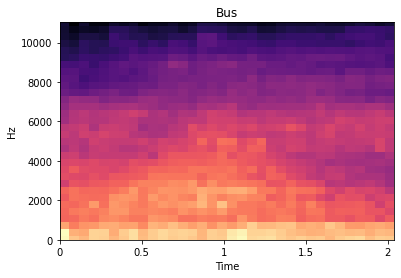

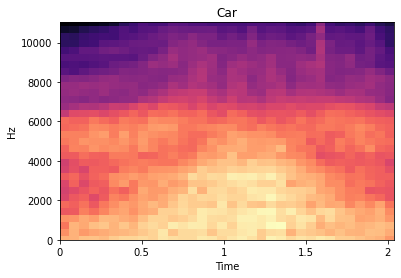

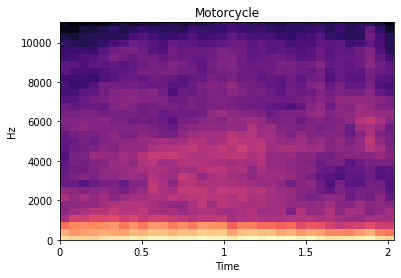

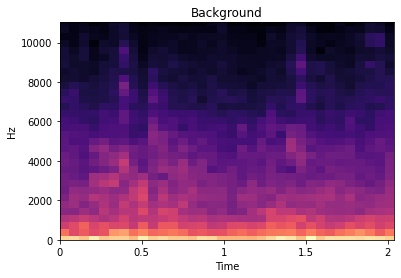

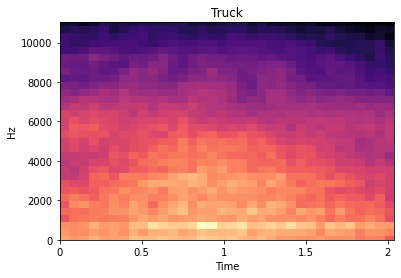

In [5]:
# set parameters
win_len_ms = 120
overlap = 0.5
sampling_rate = 22050 # use a lower sampling rate
num_mels = 32

# get the window length in samples
win_len = int((win_len_ms * sampling_rate) / 1000)
hop_len = int(win_len * (1 - overlap))
nfft = int(2 ** np.ceil(np.log2(win_len)))

for vt in vehicle_type:
    files = list(df[df.vehicle == vt].file)
    files = [item + '.mp3' for item in files]
    fn = random.choice(files)
    signal, _ =  librosa.load(os.path.join(data_dir, 
                                           fn), 
                              sampling_rate)

    file_features = librosa.feature.melspectrogram(signal,
                                                   sr=sampling_rate,
                                                   n_fft=nfft,
                                                   hop_length=hop_len,
                                                   win_length=win_len,
                                                   window='hamming',
                                                   n_mels=num_mels)
    features_dB = librosa.power_to_db(file_features, ref=np.max)
    
    plt.figure()
    librosa.display.specshow(features_dB,
                             x_axis='time',
                             y_axis='linear',
                             sr=sampling_rate,
                             fmax=sampling_rate // 2,
                             hop_length=hop_len,
                             cmap='magma')
    plt.title(annotation[fn])

### Dataset class distribution

Let us explore the class distribution of the data. Compare this with Table II of the paper.

In [6]:
training_annotation_file = 'files/eusipco_2021_train.csv'
df = pd.read_csv(training_annotation_file)

for vt in vehicles:
    print(vehicle_type[vt], len(df[df.vehicle == vt]))

Bus 0
Car 2745
Motorcycle 147
Background 2659
Truck 322


In [7]:
testing_annotation_file = 'files/eusipco_2021_test.csv'
df = pd.read_csv(testing_annotation_file)

for vt in vehicles:
    print(vehicle_type[vt], len(df[df.vehicle == vt]))

Bus 0
Car 1157
Motorcycle 99
Background 1412
Truck 189


## Data Preparation
To buid a model to classify the vehicles, we will need to extract melspectrograms from the entire dataset. The parameters used to extract the features are:
* Window size: 80 milliseconds
* Overlap: 50%
* Number of mel filter banks: 32
* Sampling rate: 16000 (less than the native rate of 48kHz)
* Duration: 2 seconds - recording length

These parameters are stored in a configuration file `files/parameters.ini`.





### Data Visualization
First, let us visualize the melspectrograms generated.

In [8]:
# get parameters used to generate melspectrograms

config = configparser.ConfigParser()
config.read('files/parameters.ini')


win_len_ms = int(config['audio']['win_len_ms'])
overlap = float(config['audio']['overlap'])
sampling_rate = int(config['audio']['sampling_rate'])
num_mels = int(config['audio']['num_mel'])
duration = float(config['audio']['duration'])

# Derive audio processing values
win_len = int((win_len_ms * sampling_rate) / 1000)
hop_len = int(win_len * (1 - overlap))
nfft = int(2 ** np.ceil(np.log2(win_len)))

Determine the true labels for the training and test files.

In [9]:
# get the melspectrogram files and labels
mel_dir = 'data/melspec-16kHz-mp3/'
filenames = os.listdir(mel_dir)

train_annotation_file = 'files/eusipco_2021_train.csv'
test_annotation_file = 'files/eusipco_2021_test.csv'

df_train = pd.read_csv(train_annotation_file)
df_test = pd.read_csv(test_annotation_file)

train_filenames = [filename + '.npy' for filename in df_train.file] 
test_filenames = [filename + '.npy' for filename in df_test.file]


vehicles = sorted(list(set(df_train.vehicle)))
vehicle_type = {'B': 'Bus', 
                'C': 'Car', 
                'M': 'Motorcycle', 
                'None': 'Background', 
                'T': 'Truck'}

train_labels = [vehicles.index(item) for item in df_train.vehicle]
test_labels = [vehicles.index(item) for item in df_test.vehicle]

train_annotation = dict(zip(train_filenames, train_labels))
test_annotation = dict(zip(test_filenames, test_labels))

Visualise the files

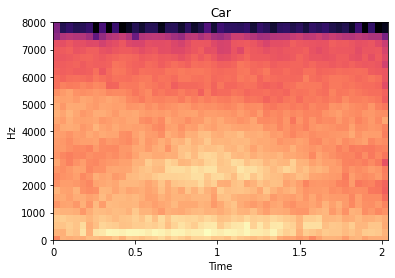

In [10]:
filename = random.choice(train_filenames)
features_db = np.load(os.path.join(mel_dir, filename))

librosa.display.specshow(features_db,
                         x_axis='time',
                         y_axis='linear',
                         sr=sampling_rate,
                         fmax=sampling_rate // 2,
                         hop_length=hop_len,
                         cmap='magma')
plt.title(vehicle_type[vehicles[train_annotation[filename]]]);


###  Normalization
It is often advantageous to normalize data before using it to train machine learning models. For melspectrograms, we normalize across the frequency channels to ensure each channel has zero mean and unit variance. We can compare the normalized and unnormalized melspectrograms to see if any information is lost. 

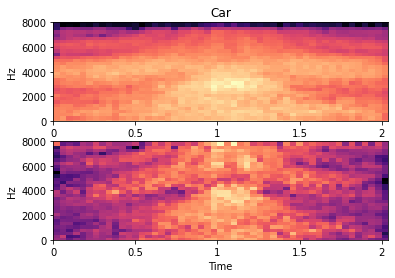

In [11]:
filename = random.choice(train_filenames)
features_db = np.load(os.path.join(mel_dir, filename))
norm_features = (features_db.T - np.mean(features_db, 1)) / np.std(features_db, 1)


plt.subplot(211)
librosa.display.specshow(features_db,
                         x_axis='time',
                         y_axis='linear',
                         sr=sampling_rate,
                         fmax=sampling_rate // 2,
                         hop_length=hop_len,
                         cmap='magma')

plt.title(vehicle_type[vehicles[train_annotation[filename]]])

plt.subplot(212)
librosa.display.specshow(norm_features.T,
                         x_axis='time',
                         y_axis='linear',
                         sr=sampling_rate,
                         fmax=sampling_rate // 2,
                         hop_length=hop_len,
                         cmap='magma')



## Model Development
After generation of melspectrograms from all the recordings, we can now move to model development. We can leverage well known architectures including:
* VGG
* ResNet
* MobileNet

Here we will focus in the VGG network.

## Neural Network Training


In [12]:
# create vgg model
num_classes = 4
frame_rate = hop_len / sampling_rate
input_shape = (num_mels, 2 * math.floor((0.5 * duration) / frame_rate), 3)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
x = base_model.output
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)

output = layers.Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

# freeze the base layers
for layer in base_model.layers:
    layer.trainable = False

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

model.summary()

2021-09-23 23:04:51.051195: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-23 23:04:51.051962: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ciira/torch/install/lib:/home/ciira/torch/install/lib:/home/ciira/torch/install/lib:/home/ciira/torch/install/lib::/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64
2021-09-23 23:04:51.052067: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ciira/torch/install/lib:/home/ciira/torch/install/lib:/home/ciira/torch/install/lib:/home/ciira/torch/in

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 50, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 50, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 50, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 25, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 25, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 25, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 12, 128)        0     

## Training Data Split
We will divide the training set into two for training (70%) and validation (30%).

In [13]:
training_files, validation_files = train_test_split(train_filenames, test_size=.3)

## Useful Functions
The functions below are used in training. They form the generator that will produce batches during training.

In [14]:
def generate_spectrogram_window(melspectrogram,
                                duration=1,
                                sampling_frequency=16000,
                                hop_size=256):
    """Generate a window of given duration centered at an active frame
    Args:
        melspectrogram: input melspectrogram
        duration: duration of window
        sampling_frequency: sampling frequency of audio
        hop_size: hop size per frame used to generate spectrogram
    Returns:
        spectrogram_window: the frames corresponding to the window
    """
    frame_rate = hop_size / sampling_frequency
    min_frame_number = math.floor((0.5 * duration) / frame_rate)

    index = random.randint(min_frame_number, melspectrogram.shape[1] - min_frame_number - 1)


    return melspectrogram[:, index - min_frame_number:index + min_frame_number]

def data_generator_windowed(melspectrogram_dir,
                            filelist,
                            annotation_dict,
                            batch_size,
                            shuffle=False,
                            duration=1,
                            sampling_frequency=16000,
                            hop_size=256):
    """ A generator for use in training the neural networks

    Args:
        melspectrogram_dir: directory where spectrograms are stored
        filelist: files containing the training spectrograms
        annotation_dict: a dictionary with the labels
        batch_size: batch size for training
        duration: duration of window to serve as training input
        sampling_frequency: sampling frequency of audio
        hop_size: hop size per frame used to generate spectrogram

    Yields:
        a tuple containing features and their labels
    """
    if shuffle:
        random.shuffle(filelist)
    batch_num = 0
    num_generator_calls = int(len(filelist) / batch_size)
    frame_rate = hop_size / sampling_frequency
    min_frame_number = math.floor((0.5 * duration) / frame_rate)

    while True:
        features = []
        labels = []
        for b in range(batch_size):
            melspec = np.load(os.path.join(melspectrogram_dir,
                                           filelist[batch_size * batch_num + b]))
            normed_mel = ((melspec.T - np.mean(melspec, 1)) / np.std(melspec, 1)).T


            if normed_mel.shape[1] > 2 * min_frame_number:
                data = generate_spectrogram_window(normed_mel,
                                                   duration,
                                                   sampling_frequency,
                                                   hop_size)

                if not np.isnan(data).any():

                    #features.append(data.reshape(data.shape[0], data.shape[1], 1))
                    features.append(np.stack((data,) * 3, axis=-1))
                    labels.append(annotation_dict[filelist[batch_size * batch_num + b]])

        batch_num += 1
        batch_num %= num_generator_calls

        yield np.array(features).astype('float32'), tf.one_hot(labels, len(set(annotation_dict.values())))

Create the data generators.

In [15]:
# neural network parameters
batch_size = int(config['neural-net']['batch_size'])
num_epoch = int(config['neural-net']['epochs'])

training_generator = data_generator_windowed(mel_dir,
                                            training_files,
                                            train_annotation,
                                            batch_size, 
                                            False, 
                                            duration, 
                                            sampling_rate, 
                                            hop_len)
validation_generator = data_generator_windowed(mel_dir,
                                              validation_files,
                                              train_annotation,
                                              batch_size, 
                                              False, 
                                              duration, 
                                              sampling_rate, 
                                              hop_len)

Set up the early stopping callback

In [16]:
es = EarlyStopping(patience=10,
                       monitor="val_accuracy",
                       restore_best_weights=True)
callbacks = [es]

Start training.

In [17]:
model.fit(training_generator,
          steps_per_epoch=len(training_files) // batch_size,
          epochs=num_epoch,
          validation_data=validation_generator,
          validation_steps=len(validation_files) // batch_size,
          callbacks=callbacks)

2021-09-23 23:04:52.934172: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/2


2021-09-23 23:04:53.879292: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 13107200 exceeds 10% of free system memory.
2021-09-23 23:04:54.074853: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 13107200 exceeds 10% of free system memory.


  1/128 [..............................] - ETA: 3:04 - loss: 2.1934 - accuracy: 0.1250

2021-09-23 23:04:54.444807: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 13107200 exceeds 10% of free system memory.
2021-09-23 23:04:54.456434: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 13107200 exceeds 10% of free system memory.


  2/128 [..............................] - ETA: 38s - loss: 1.8851 - accuracy: 0.2344 

2021-09-23 23:04:54.746231: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 13107200 exceeds 10% of free system memory.


124/128 [============================>.] - ETA: 1s - loss: 0.3435 - accuracy: 0.8919

/home/ciira/Documents/DSAIL/road-monitoring/audio-traffic-env/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide


128/128 [==============================] - 58s 448ms/step - loss: 0.3462 - accuracy: 0.8908 - val_loss: 0.2601 - val_accuracy: 0.9057
Epoch 2/2
128/128 [==============================] - 56s 441ms/step - loss: 0.2320 - accuracy: 0.9236 - val_loss: 0.2556 - val_accuracy: 0.9034


## Model Testing
After training the model, we test it using the test data which was not seen during training. We are able to verify whether the model has learnt to distinguish the classes.

<BarContainer object of 4 artists>

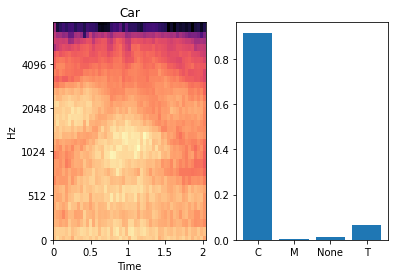

In [18]:
# test the model
filename = random.choice(test_filenames)
features_db = np.load(os.path.join(mel_dir, filename))
norm_features = ((features_db.T - np.mean(features_db, 1)) / np.std(features_db, 1)).T

input_feature = generate_spectrogram_window(norm_features,
                                   duration,
                                   sampling_rate,
                                   hop_len)
input_feature = np.stack((input_feature,) * 3, axis=-1)

input_feature = input_feature.reshape(1, input_feature.shape[0], input_feature.shape[1], input_feature.shape[2])

prob = model.predict(input_feature)


plt.subplot(121)
librosa.display.specshow(features_db,
                         x_axis='time',
                         y_axis='mel',
                         sr=sampling_rate,
                         fmax=sampling_rate // 2,
                         hop_length=hop_len,
                         cmap='magma')

plt.title(vehicle_type[vehicles[test_annotation[filename]]])
plt.subplot(122)
plt.bar(np.arange(prob.shape[1]), prob[0,:], tick_label=vehicles)

## Testing the model on locally collected data

In [19]:
data_dir = 'data/pi-audio/'
filenames = os.listdir(data_dir)

filename = random.choice(filenames)
signal, _ =  librosa.load(os.path.join(data_dir,
                                       filename),
                          sampling_rate)
IPython.display.Audio(data=signal, rate=sampling_rate)

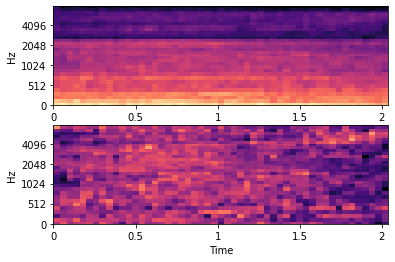

In [20]:
mel = librosa.feature.melspectrogram(signal,
                                   sr=sampling_rate,
                                   n_fft=nfft,
                                   hop_length=hop_len,
                                   win_length=win_len,
                                   window='hamming',
                                   n_mels=num_mels)

features_dB = librosa.power_to_db(mel, ref=np.max)
norm_features = ((features_dB.T - np.mean(features_dB, 1)) / np.std(features_dB, 1)).T

plt.subplot(211)
librosa.display.specshow(features_dB,
                         x_axis='time',
                         y_axis='mel',
                         sr=sampling_rate,
                         fmax=sampling_rate // 2,
                         hop_length=hop_len,
                         cmap='magma')
plt.subplot(212)
librosa.display.specshow(norm_features,
                         x_axis='time',
                         y_axis='mel',
                         sr=sampling_rate,
                         fmax=sampling_rate // 2,
                         hop_length=hop_len,
                         cmap='magma')

<BarContainer object of 4 artists>

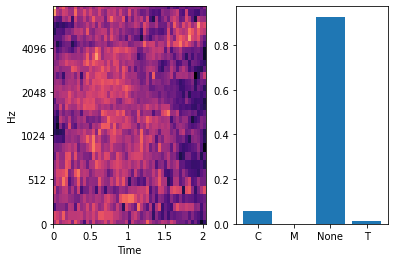

In [21]:
input_feature = generate_spectrogram_window(norm_features,
                                   duration,
                                   sampling_rate,
                                   hop_len)
input_feature = np.stack((input_feature,) * 3, axis=-1)

input_feature = input_feature.reshape(1, input_feature.shape[0], input_feature.shape[1], input_feature.shape[2])

prob = model.predict(input_feature)


plt.subplot(121)
librosa.display.specshow(norm_features,
                         x_axis='time',
                         y_axis='mel',
                         sr=sampling_rate,
                         fmax=sampling_rate // 2,
                         hop_length=hop_len,
                         cmap='magma')


plt.subplot(122)
plt.bar(np.arange(prob.shape[1]), prob[0,:], tick_label=vehicles)